# DR12Q Superset Evaluation

In [1]:
using CSV, DataFrames, FITSIO, Flux, HDF5, Plots, Random, Statistics

In [2]:
include("BayesianSZNet.jl")
using .BayesianSZNet

In [3]:
dr12q_superset = h5open("data/dr12q_superset.hdf5", "r")
# load data
id_tr = read(dr12q_superset, "id_tr")
id_va = read(dr12q_superset, "id_va")
id_te = read(dr12q_superset, "id_te")
X_va = read(dr12q_superset, "X_va")
X_te = read(dr12q_superset, "X_te")
X_va_gpu = gpu(X_va)
X_te_gpu = gpu(X_te)
z_tr = reshape(read(dr12q_superset, "z_vi_va"), 1, :)
z_va = reshape(read(dr12q_superset, "z_vi_va"), 1, :)
z_te = reshape(read(dr12q_superset, "z_vi_te"), 1, :)
# create DR12Q superset test DataFrame
dr12q_superset_df = DataFrame(
    plate=id_te[1, :], mjd=id_te[2, :], fiberid=id_te[3, :],
    z_vi=z_te[:], z_pipe=read(dr12q_superset, "z_pipe_te"))
close(dr12q_superset)
dr12q_superset_df

,plate,mjd,fiberid,z_vi,z_pipe
,Int32,Int32,Int32,Float32,Float32
1,3770,55234,330,0.0,-0.000147199
2,3958,55329,650,0.0,0.251944
3,6687,56602,78,1.997,1.99684
4,6514,56487,46,0.0,0.000517183
5,5309,55929,268,0.0,0.000302015
6,5799,56325,896,2.51,2.49976
7,3812,55513,770,0.0,0.000320564
8,5463,56003,634,2.172,2.17091
9,4731,55656,170,0.823,0.822519


In [4]:
minimum(z_tr), maximum(z_tr)

(-0.008f0, 5.216f0)

In [5]:
# write filenames of spectra to files
writelst("data/dr12q_superset_train.lst", id_tr[1, :], id_tr[2, :], id_tr[3, :])
writelst("data/dr12q_superset_valid.lst", id_va[1, :], id_va[2, :], id_va[3, :])
writelst("data/dr12q_superset_test.lst", id_te[1, :], id_te[2, :], id_te[3, :])

In [6]:
# data for cross-match (using TOPCAT) with the DR16Q superset
# read metadata of DR12Q superset
dr12q_catalog_fits = FITS("data/Superset_DR12Q.fits")
dr12q_catalog_df = DataFrame(
        plate=read(dr12q_catalog_fits[2], "PLATE"),
        mjd=read(dr12q_catalog_fits[2], "MJD"),
        fiberid=read(dr12q_catalog_fits[2], "FIBERID"),
        ra=read(dr12q_catalog_fits[2], "RA"),
        dec=read(dr12q_catalog_fits[2], "DEC"))
close(dr12q_catalog_fits)
# create DataFrame of train and validation identifiers
id_crossmatch = cat(id_tr, id_va, dims=2)
crossmatch_df = DataFrame(
        plate=id_crossmatch[1, :], mjd=id_crossmatch[2, :], fiberid=id_crossmatch[3, :])
crossmatch_df = leftjoin(crossmatch_df, dr12q_catalog_df, on=[:plate, :mjd, :fiberid])
CSV.write("data/dr12q_superset_train_valid.csv", crossmatch_df)
crossmatch_df

,plate,mjd,fiberid,ra,dec
,Int32,Int32,Int32,Float64?,Float64?
1,6511,56540,156,0.000930924,27.9648
2,7147,56574,160,0.00120697,-7.51523
3,6127,56274,950,0.00152203,20.2191
4,6173,56238,528,0.00189829,17.7737
5,6207,56239,156,0.00191678,17.8025
6,6511,56540,82,0.00251526,26.6894
7,6177,56268,595,0.00275643,14.9747
8,4415,55831,464,0.00405239,4.82978
9,4354,55810,678,0.00531697,-2.03327


In [7]:
dr16q_superset = h5open("data/dr16q_superset.hdf5", "r")
id_dr16q = read(dr16q_superset, "id")
dr16q_superset_df = DataFrame(
    plate=id_dr16q[1, :], mjd=id_dr16q[2, :], fiberid=id_dr16q[3, :],
    z_qn_dr16q=read(dr16q_superset, "z_qn"),
    z_pca_dr16q=read(dr16q_superset, "z_pca"),
    z_pipe_dr16q=read(dr16q_superset, "z_pipe"))
close(dr16q_superset)
dr16q_superset_df

,plate,mjd,fiberid,z_qn_dr16q,z_pca_dr16q,z_pipe_dr16q
,Int32,Int32,Int32,Float32,Float32,Float32
1,266,51630,3,-1.0,0.652749,-1.0
2,266,51630,58,-1.0,1.4742,-1.0
3,266,51630,80,-1.0,1.77093,-1.0
4,266,51630,126,-1.0,0.517986,-1.0
5,266,51630,161,-1.0,0.325552,-1.0
6,266,51630,200,-1.0,0.288502,-1.0
7,266,51630,208,-1.0,1.36318,-1.0
8,266,51630,225,-1.0,1.61713,-1.0
9,266,51630,238,-1.0,1.58855,-1.0


In [8]:
superset_df = dropmissing(leftjoin(dr12q_superset_df, dr16q_superset_df, on=[:plate, :mjd, :fiberid]))

,plate,mjd,fiberid,z_vi,z_pipe,z_qn_dr16q,z_pca_dr16q,z_pipe_dr16q
,Int32,Int32,Int32,Float32,Float32,Float32,Float32,Float32
1,3586,55181,40,0.0,-0.000495647,0.978651,-0.0219896,-0.00049504
2,3586,55181,94,0.0,-0.000131985,2.15852,0.000578144,-0.000124888
3,3586,55181,98,0.717,0.716731,0.715097,0.716448,0.716641
4,3586,55181,114,2.229,2.22907,2.22853,2.2253,2.22932
5,3586,55181,158,2.685,2.69454,2.67721,2.68263,2.69483
6,3586,55181,196,0.0,0.533737,1.59862,0.000156374,-0.00060219
7,3586,55181,214,0.0,7.59728e-5,2.14452,0.000112268,0.000110871
8,3586,55181,228,2.128,2.13232,2.14809,2.12088,2.1233
9,3586,55181,300,0.0,-0.000580457,1.14103,-0.0232965,-0.000508844


## Bayesian FCNN

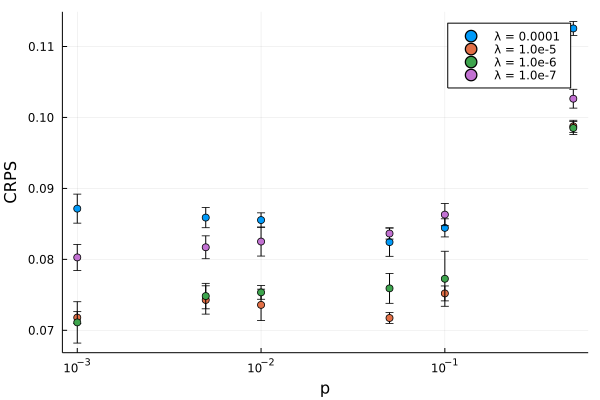

In [9]:
fcnn_df = CSV.read("data/fcnn.csv", DataFrame)
s = scatter()
for gdf in groupby(fcnn_df, :λ)
    aggdf = combine(groupby(gdf, :p), :mcrps .=> [mean, confint])
    s = scatter!(
        aggdf.p, aggdf.mcrps_mean, yerror=aggdf.mcrps_confint,
        xlabel="p", ylabel="CRPS", label="λ = $(gdf.λ[1])", xscale=:log10)
end
s

In [10]:
z_va_long = hcat(z_va, z_va, z_va, z_va, z_va)

1×250000 Array{Float32,2}:
 0.0  0.0  2.737  1.422  2.455  0.563  …  2.275  2.781  2.373  0.838  0.433

In [11]:
dr12q_superset = h5open("data/dr12q_superset.hdf5", "r")
fcnn_group = dr12q_superset["fcnn"]
ẑs_fcnn_05 = read(fcnn_group, "zs_pred_05")
ẑs_fcnn_01 = read(fcnn_group, "zs_pred_01")
ẑs_fcnn_005 = read(fcnn_group, "zs_pred_005")
ẑs_fcnn_001 = read(fcnn_group, "zs_pred_001")
close(dr12q_superset)

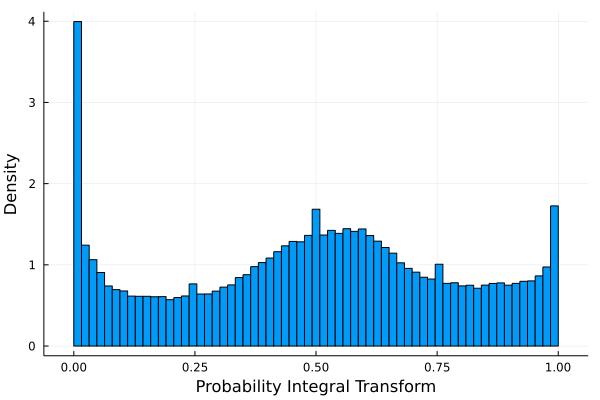

In [12]:
pithist(z_va_long, reshape(ẑs_fcnn_05, 256, :))

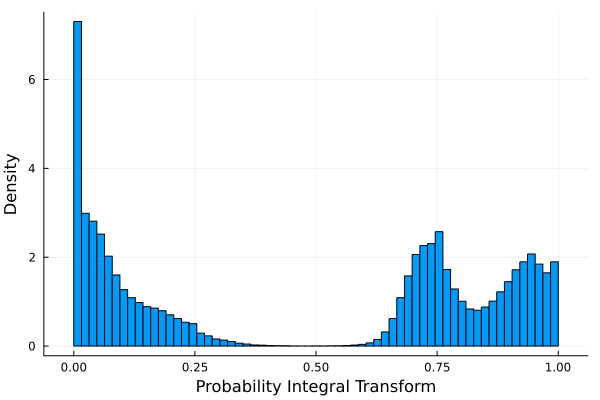

In [13]:
pithist(z_va_long, reshape(ẑs_fcnn_01, 256, :))

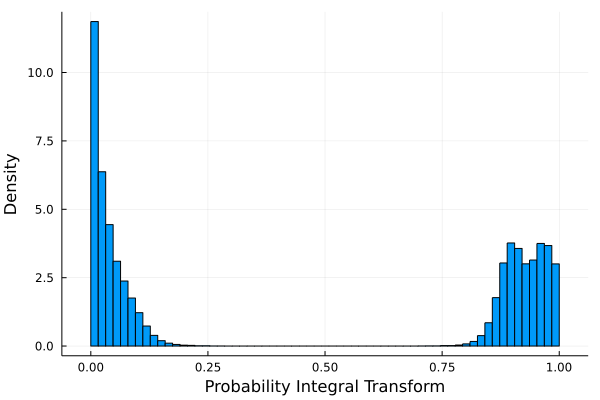

In [14]:
pithist(z_va_long, reshape(ẑs_fcnn_005, 256, :))

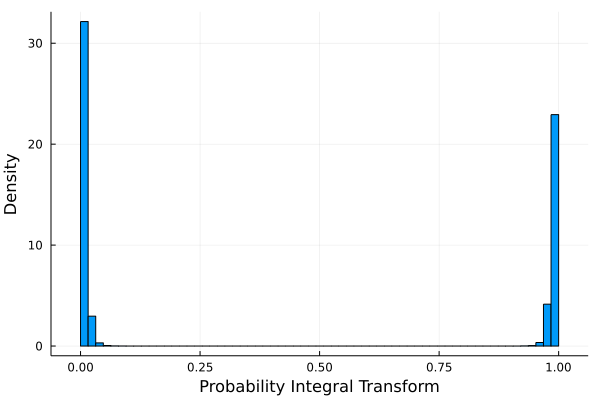

In [15]:
pithist(z_va_long, reshape(ẑs_fcnn_001, 256, :))

In [16]:
function evaluate(z, ẑss)
    ẑs = mean(ẑss, dims=1)
    for i in 1:5
        println("CRPS = ", mcrps(z_va, ẑss[:, :, i]), "\tRMSE = ", rmse(z_va, ẑs[:, :, i]))
    end
end

evaluate (generic function with 1 method)

In [17]:
evaluate(z_va, ẑs_fcnn_05)

0.0716704446270101	RMSE = 0.2093488104600706
CRPS = 0.07119461398586611	RMSE = 0.20706518572439828
CRPS = 0.07128089664282672	RMSE = 0.20838375628029365
CRPS = 0.07186629818094485	RMSE = 0.20987100658293664


## Bayesian SZNet

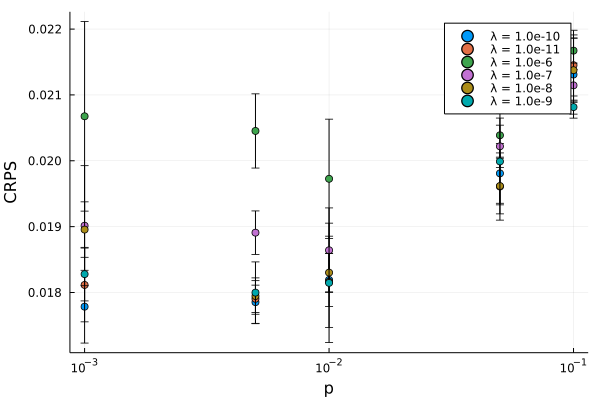

In [18]:
sznet_df = CSV.read("data/sznet.csv", DataFrame)
sznet_df = sznet_df[(sznet_df.λ .< 1e-5) .& (sznet_df.p .< 0.5), :]
s = scatter()
for gdf in groupby(sznet_df, :λ)
    aggdf = combine(groupby(gdf, :p), :mcrps .=> [mean, confint])
    s = scatter!(
        aggdf.p, aggdf.mcrps_mean, yerror=aggdf.mcrps_confint,
        xlabel="p", ylabel="CRPS", label="λ = $(gdf.λ[1])", xscale=:log10)
end
s

In [19]:
dr12q_superset = h5open("data/dr12q_superset.hdf5", "r")
sznet_group = dr12q_superset["sznet"]
ẑs_sznet_05 = read(sznet_group, "zs_pred_05")
ẑs_sznet_01 = read(sznet_group, "zs_pred_01")
ẑs_sznet_005 = read(sznet_group, "zs_pred_005")
ẑs_sznet_001 = read(sznet_group, "zs_pred_001")
close(dr12q_superset)

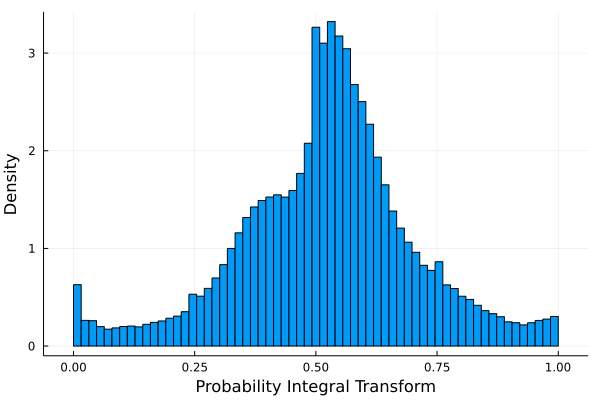

In [20]:
pithist(z_va_long, reshape(ẑs_sznet_05, 256, :))

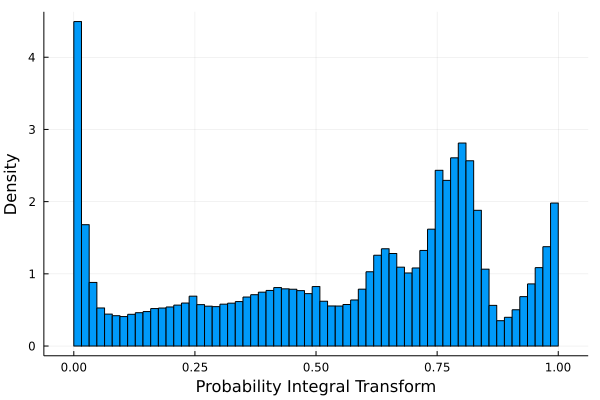

In [21]:
pithist(z_va_long, reshape(ẑs_sznet_01, 256, :))

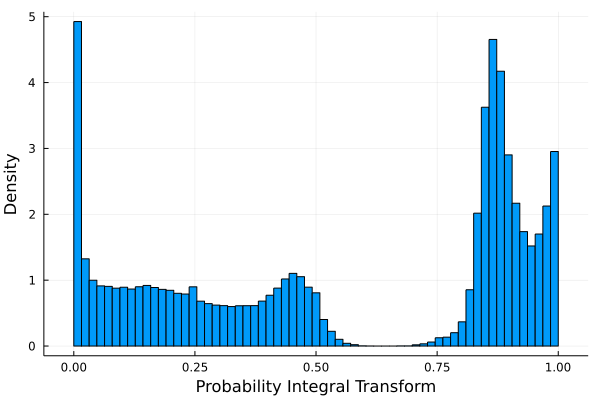

In [22]:
pithist(z_va_long, reshape(ẑs_sznet_005, 256, :))

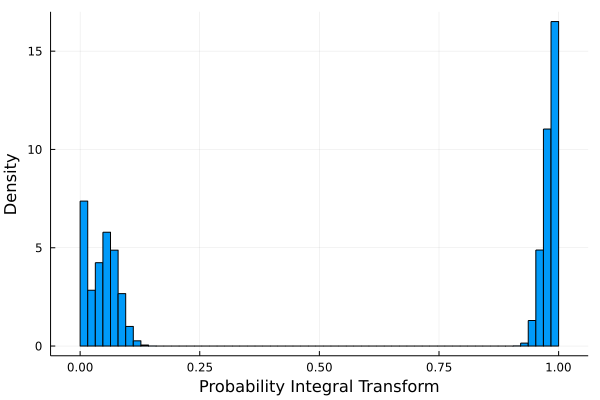

In [23]:
pithist(z_va_long, reshape(ẑs_sznet_001, 256, :))

In [24]:
evaluate(z_va, ẑs_sznet_01)

CRPS = 0.017498289712100178	RMSE = 0.110642820318586
CRPS = 0.017980296481245668	RMSE = 0.10873827848676684
CRPS = 0.018891762053486034	RMSE = 0.10375892186238321
CRPS = 0.017417336328339396	RMSE = 0.10767015410780532
CRPS = 0.01894543022978247	RMSE = 0.11070845828021515


## Evaluation on Test Set

In [25]:
size(dr12q_superset_df, 1) - size(superset_df, 1)

113

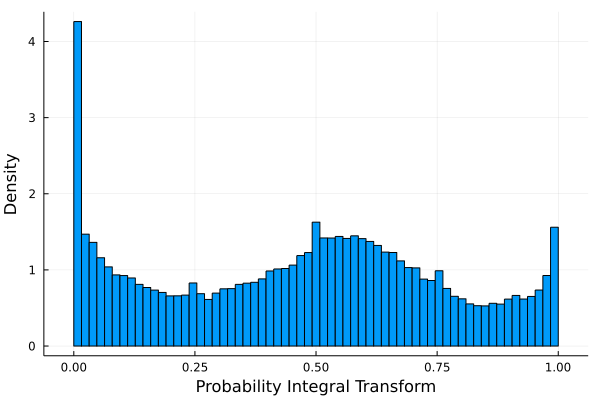

In [26]:
fcnn = FCNN("models/fcnn_3_0.05_1.0e-5.bson")
ẑs_fcnn_te = sample(fcnn, X_te_gpu)
pithist(z_te, ẑs_fcnn_te)

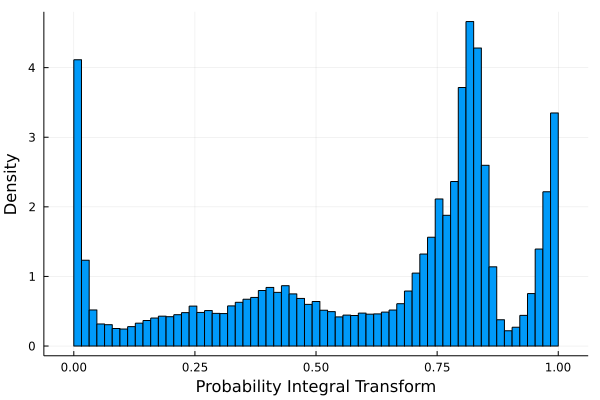

In [27]:
sznet = SZNet("models/sznet_4_0.01_1.0e-9.bson")
ẑs_te = sample(sznet, X_te_gpu)
pithist(z_te, ẑs_te)

In [28]:
getcol(df, col) = Flux.unsqueeze(df[:, col], 1)
z_vi = getcol(dr12q_superset_df, "z_vi")
z_pipe = getcol(dr12q_superset_df, "z_pipe")
z_vi_dr16q = getcol(superset_df, "z_vi")
z_pipe_dr16q = getcol(superset_df, "z_pipe_dr16q")
z_pca_dr16q = getcol(superset_df, "z_pca_dr16q")
z_qn_dr16q = getcol(superset_df, "z_qn_dr16q")

1×49887 Array{Float32,2}:
 0.978651  2.15852  0.715097  2.22853  …  1.59083  3.26379  1.27599  -1.0

In [29]:
ẑ_fcnn_te = mean(ẑs_fcnn_te, dims=1)
mcrps(z_vi, ẑs_fcnn_te), rmse(z_vi, ẑ_fcnn_te)

(0.07124785f0, 0.21067140908450602)

In [30]:
ẑ_te = mean(ẑs_te, dims=1)
mcrps(z_vi, ẑs_te), rmse(z_vi, ẑ_te)

(0.017104845f0, 0.10839399520255252)

In [31]:
mcrps(z_vi, z_pipe), rmse(z_vi, z_pipe)

(0.0968928f0, 0.5001885263307255)

In [32]:
mcrps(z_vi_dr16q, z_pipe_dr16q), rmse(z_vi_dr16q, z_pipe_dr16q)

(0.08297017f0, 0.4518096112397242)

In [33]:
mcrps(z_vi_dr16q, z_pca_dr16q), rmse(z_vi_dr16q, z_pca_dr16q)

(0.072406135f0, 0.41181859159937256)

In [34]:
mcrps(z_vi_dr16q, z_qn_dr16q), rmse(z_vi_dr16q, z_qn_dr16q)

(0.681183f0, 1.1530277585408146)